In [1]:
from collections import defaultdict

import logging
import os
import time

from bs4 import BeautifulSoup, element as bs4_element
import numpy as np
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO)

In [3]:
class LinkedIn:
    
    def __init__(self, snooze=2):
        
        logging.info('Setting Up LinkedIn')
        self.snooze = snooze
         

    def sign_in(self, username, password):
        logging.info('Login in LinkedIn')
        self.username = username
        self.password = password
        
        # Remove the Automation Info 
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--disable-infobars")
        driver = webdriver.Chrome(options=chrome_options)
        
        driver.get('https://www.linkedin.com/login')
    
        user_name = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'username'))
        )
        user_name.clear()
        user_name.send_keys(self.username)
    
        user_pwd = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'password'))
        )
        user_pwd.clear()
        user_pwd.send_keys(self.password)
        user_pwd.submit()
        
        self.driver = driver
        
        logging.info('Login Successful')
        return self
    
    def sign_off(self, soup=True):
        
        time.sleep(5)
        
        if soup:
            self.soup = BeautifulSoup(self.driver.page_source, 'lxml')
            logging.info('Logoff with soup')
            
        self.driver.close()
        logging.info('Logoff Successful')
        return self
    
    
    @property
    def connections(self):
        
        WebDriverWait(self.driver, 10).until(
            EC.presence_of_element_located((By.ID, 'mynetwork-tab-icon'))
        ).click()

        WebDriverWait(self.driver, 30).until(
            EC.presence_of_element_located(
                (By.CLASS_NAME, 'mn-community-summary__entity-info'))
        ).click()
        
        return self
    
    
    @property
    def scroll(self):

        KEEP_SCROLLING = True

        # Get current scrol height
        current_height = self.driver.execute_script("return document.body.scrollHeight")
        
        logging.info('Scrolling in progress ...')
        print('\n[.', end='')
        while KEEP_SCROLLING:

            # Scroll down to bottom
            self.driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

            # Wait to load page
            time.sleep(self.snooze)

            # Get the new scrolled height
            scrolled_height = self.driver.execute_script("return document.body.scrollHeight")
            # Check if we should keep scrolling
            
            
            if scrolled_height == current_height:
                KEEP_SCROLLING = False
            current_height = scrolled_height
            print('.', end='')
        print(']\n')
        
        logging.info('Scrolling Completed!')   
        return self     

In [4]:
class LinkedInSoup:
    
    def __init__(self, soup):
        
        if not isinstance(soup, bs4_element.Tag):
            logging.error(f'Beautiful soup element required. {type(soup)} was given')
        self.soup = soup
        self.store = defaultdict(list)
        
    def __repr__(self):
        
        show = ''
        if self.store:
            index = np.random.randint(0, len(self.store)+1, 5)
            names = [name for i,name in enumerate(self.store['profile_name']) if i in index]
            for name in names:
                show+=f".Node('{name}')"
                
        else:
            show = '.Node()'
        
        return show[1:]
        
    def prep_connection(self, image=False):
        
        section = self.soup.find('section',class_='mn-connections')
        connections = section.find_all('li', class_='list-style-none')
        logging.info(f'{len(connections)} connections found')
        
        for profile in connections:
            
            p = profile.find('a',{'data-control-name':'connection_profile'})
            self.store['profile_url'].append(p['href'])
            self.store['profile_name'].append(p.img['alt'])
            if image:                             
                self.store['profile_img_url'].append(p.img['src'])
            
            title = profile.find('span',class_='mn-connection-card__occupation').get_text(strip=True)
            self.store['title'].append(title)
            
        return self
        

In [5]:
user = os.environ.get('LINKEDIN_USER')
pwd = os.environ.get('LINKEDIN_PWD')

In [8]:
linkedin = LinkedIn(.5)

23-Jul-19 17:26:56 [INFO] Setting Up LinkedIn


In [9]:
try:
    
    network = linkedin.sign_in(username=user,password=pwd)
    network.connections.scroll
    
finally:
    
    linkedin.sign_off()

23-Jul-19 17:26:56 [INFO] Login in LinkedIn
23-Jul-19 17:27:05 [INFO] Login Successful
23-Jul-19 17:27:07 [INFO] Scrolling in progress ...



[................................

23-Jul-19 17:30:14 [INFO] Scrolling Completed!


.]



23-Jul-19 17:30:21 [INFO] Logoff with soup
23-Jul-19 17:30:21 [INFO] Logoff Successful


In [11]:
connections = LinkedInSoup(linkedin.soup)

In [12]:
connections.prep_connection()

23-Jul-19 17:30:29 [INFO] 998 connections found


Node('Daylian Opare').Node('Jimmy Daniel').Node('Tristan Steindor')

In [13]:
len(connections.store['profile_url'])

998

In [14]:
df = pd.DataFrame(connections.store)
df.head()

,profile_url,profile_name,title
0,/in/daylian-opare-35951216a/,Daylian Opare,Solutions Consultant at Orcan Intelligence Ltd
1,/in/jimmy-daniel-39761312a/,Jimmy Daniel,"Doctor, Medical Director"
2,/in/devilliersneethling/,De Villiers Neethling,"Experienced Software Developer, specialising i..."
3,/in/tristansteindor/,Tristan Steindor,merges & develops innovation
4,/in/farshad-badie/,"Farshad Badie, PhD","Logician, Information Scientist, Theoretical A..."


In [15]:
soup = linkedin.soup

In [16]:
section = soup.find('section',class_='mn-connections')
connections = section.find_all('li', class_='list-style-none')
print(len(connections))

998


In [17]:
s = connections[0].find('a',{'data-control-name':'connection_profile'})

In [18]:
s

<a class="mn-connection-card__picture pt2 pr2 pb1 pl5 ember-view" data-control-name="connection_profile" href="/in/daylian-opare-35951216a/" id="ember1237"> <div class="presence-entity presence-entity--size-5 ember-view" id="ember1238"><img alt="Daylian Opare" class="lazy-image presence-entity__image EntityPhoto-circle-5 loaded" src="https://media.licdn.com/dms/image/C4D03AQHRL2FyhP1edQ/profile-displayphoto-shrink_800_800/0?e=1569456000&amp;v=beta&amp;t=I2HcQEhx1O92Y890POHr4YRBNfwyUkenRBMGlxmEH4w"/>
<div class="presence-entity__indicator presence-entity__indicator--size-5 presence-indicator hidden presence-indicator--size-5 ember-view" id="ember1239">
<span class="visually-hidden">
    Status is offline
  </span>
</div>
</div>
</a>

In [19]:
s['href']

'/in/daylian-opare-35951216a/'

In [20]:
s.img['alt']

'Daylian Opare'

In [21]:
s.img['src']

'https://media.licdn.com/dms/image/C4D03AQHRL2FyhP1edQ/profile-displayphoto-shrink_800_800/0?e=1569456000&v=beta&t=I2HcQEhx1O92Y890POHr4YRBNfwyUkenRBMGlxmEH4w'

In [22]:
connections[0].find('span',class_='mn-connection-card__occupation').get_text(strip=True)

'Solutions Consultant at Orcan Intelligence Ltd'

In [23]:
import requests
from IPython.display import Image

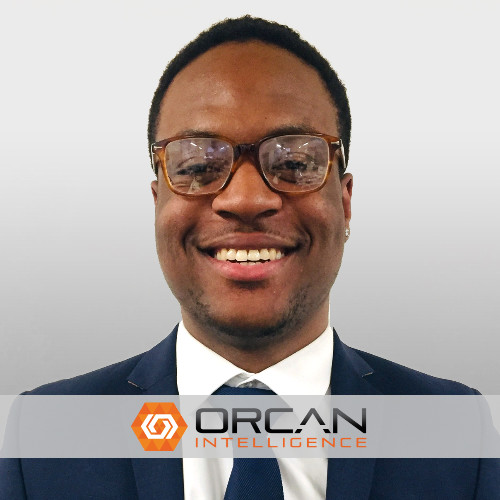

In [24]:
Image(requests.get(s.img['src']).content)

In [25]:
requests.get(s.img['src']).content

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x01\xf4\x01\xf4\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x01\x00\x00\x07\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\xff\xc4\x00c\x10\x00\x01\x02\x04\x04\x03\x05\x03\x06\x08\x07\n\n\x06\x0b\x00\x01\x02\x03\x00\x04\x11\x12\x05\x06!1\x07Aa\x08\x13"Qq\x14\x81\x91\x152\xa1\xb1\xd3\xf0\t\x16#BR\xc1\xd1\xe1\x183b\x92\x94\x

In [26]:
df.to_pickle('linkedin.pkl')

In [28]:
df.iloc[0]['profile_url']

'/in/daylian-opare-35951216a/'

In [29]:
ROOT_URL = 'https://www.linkedin.com'